In [1]:
import tensorflow.config as tc

In [2]:
print(tc.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Import API's

In [3]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

# Preparing DataSets 

In [4]:
# Load Portuguese to English Datasets
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

# Devide Train and Validation Datasets
train_examples, val_examples = examples['train'], examples['validation']

# Check Datasets

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    
    # Portuguese
    for pt in pt_examples.numpy():
        # Decode UTF-8
        print(pt.decode('utf-8'))
        
    # Print Blank    
    print()
    
    # English
    for en in en_examples.numpy():
        # Decode UTF-8
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


# Text Tokenization & Detokenization

In [6]:
# Download Pretrained Model

model_name = "ted_hrlr_translate_pt_en_converter"

tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
# Load Pretrained Model

tokenizers = tf.saved_model.load(model_name)

# Check Tokenizer's item

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

# Tokenize English Example

In [9]:
encoded = tokenizers.en.tokenize(en_examples)

In [10]:
for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


# Detokenize English Example

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

In [12]:
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


**Make Lower Lookup**

In [13]:
tokens = tokenizers.en.lookup(encoded)

In [14]:
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

# Setting Input Pipelines

In [15]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()
    
    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
    return (ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

In [18]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

# Positional Encoding

In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1/np.power(10000, (2* (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [20]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

(1, 2048, 512)


In [22]:
pos_encoding = pos_encoding[0]

# Juggle the dimensions for a plot

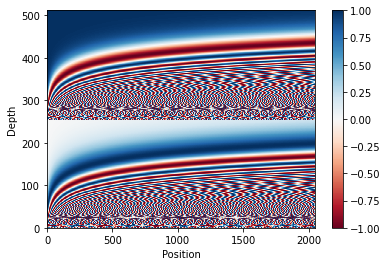

In [23]:
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap= 'RdBu')
plt.ylabel("Depth")
plt.xlabel("Position")
plt.colorbar()
plt.show()

# Masking

In [24]:
def creating_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # batch_size,  1, 1, sequence_length

In [25]:
# For Testing
x = tf.constant([[7,6,0,0,1], [1,2,3,0,0], [0,0,0,4,5]])
creating_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [26]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask #(seq_len, seq_len)

In [27]:
# For Testing
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled Dot-Product Attention

In [28]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape   == (..., seq_len_k, depth)
      v: value shape -- (..., seq_len_v, depth)
      mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None
    
    Returns:
      output, attention_weights
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask* -1e9)
    else:
        pass
        
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [29]:
# Printing Attention map

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print("Attention Weights are: ")
    print(temp_out)
    print("Attention Scores : ")
    print(temp_attn)

In [30]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                     [0,10,0],
                     [0,0,10],
                     [0,0,10]], dtype=tf.float32) # (4,3)
temp_v = tf.constant([[  1,0],
                     [  10,0],
                     [ 100,5],
                     [1000,6]], dtype=tf.float32) # (4,2)

# This 'query' aligns with the second 'key'.
# so the second 'value' is returned.

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1,3)
print_out(temp_q, temp_k, temp_v)

Attention Weights are: 
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention Scores : 
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


# Multi Head Attention

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model
        self.num_heads =  num_heads
        
        assert self.d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_head(self, x, batch_size):
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])
        
        
    def call(self, v, k, q, mask):
        
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_head(q, batch_size)
        k = self.split_head(k, batch_size)
        v = self.split_head(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point-wise Feed Forward Network

In [33]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoding Layer

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer,self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2


In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

# Decoding Layer

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):# enc_output.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

In [39]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,  maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    
    def call(self, x, training, mask):
        
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x  # (batch_size, input_seq_len, d_model)

In [40]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder

In [41]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2  # x.shape == (batch_size, target_seq_len, d_model)
        
        return x, attention_weights

In [42]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, maximum_position_encoding=5000)

temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,enc_output=sample_encoder_output, training=False, look_ahead_mask=None,padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Create Transformer

In [43]:
class Transformer(tf.keras.Model):
    
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        
        enc_output = self.tokenizer(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [44]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8,
                                 dff=2048, input_vocab_size=8500, target_vocab_size=8000,
                                 pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Setting Hyperparameter

In [45]:
num_layers  = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# Make Custom Scheduler

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step *(self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [48]:
temp_learning_rate_schedule = CustomSchedule(d_model)

Text(0.5, 0, 'Train Step')

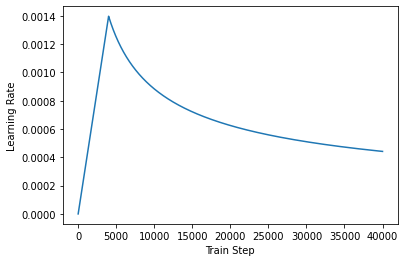

In [49]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *=mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [52]:
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [53]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.Mean(name="train_accuracy")

# Transformer

In [54]:
transformer = Transformer(num_layers=num_layers, d_model=d_model,
                         num_heads=num_heads, dff=dff,
                         input_vocab_size=tokenizers.pt.get_vocab_size(),
                         target_vocab_size=tokenizers.en.get_vocab_size(),
                         pe_input=1000, pe_target=1000, rate=dropout_rate)

# Make Mask

In [55]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = creating_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = creating_padding_mask(inp)
    
    #Used in the 1st attetion block in the decoder.
    #It is used to pad and mask future tokens in the input received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask=creating_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

# Check Point

In [56]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                          optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [57]:
#if a checkpoint exists, restore the latest checkpoint.

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest Checkpoint Restore")

Latest Checkpoint Restore


# Training

In [58]:
EPOCHS = 20

In [59]:
train_step_signature = [
    tf.TensorSpec(shape =(None, None), dtype=tf.int64),
    tf.TensorSpec(shape =(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [60]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accurcy {train_accuracy.result():.4f}')
    
    if (epoch + 1) % 5 ==0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving Checkpoint for epoch {epoch +1} at {ckpt_save_path}')
        
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.4403 Accurcy 0.6673
Epoch 1 Batch 50 Loss 1.3346 Accurcy 0.6982
Epoch 1 Batch 100 Loss 1.3606 Accurcy 0.6933
Epoch 1 Batch 150 Loss 1.3801 Accurcy 0.6902
Epoch 1 Batch 200 Loss 1.3885 Accurcy 0.6886
Epoch 1 Batch 250 Loss 1.3944 Accurcy 0.6878
Epoch 1 Batch 300 Loss 1.3931 Accurcy 0.6883
Epoch 1 Batch 350 Loss 1.3948 Accurcy 0.6881
Epoch 1 Batch 400 Loss 1.4000 Accurcy 0.6875
Epoch 1 Batch 450 Loss 1.4066 Accurcy 0.6864
Epoch 1 Batch 500 Loss 1.4076 Accurcy 0.6862
Epoch 1 Batch 550 Loss 1.4105 Accurcy 0.6857
Epoch 1 Batch 600 Loss 1.4113 Accurcy 0.6857
Epoch 1 Batch 650 Loss 1.4143 Accurcy 0.6854
Epoch 1 Batch 700 Loss 1.4188 Accurcy 0.6847
Epoch 1 Batch 750 Loss 1.4222 Accurcy 0.6841
Epoch 1 Batch 800 Loss 1.4251 Accurcy 0.6836
Epoch 1 Loss 1.4257 Accuracy 0.6836
Time taken for 1 epoch: 72.15 secs

Epoch 2 Batch 0 Loss 1.3384 Accurcy 0.6909
Epoch 2 Batch 50 Loss 1.3526 Accurcy 0.6950
Epoch 2 Batch 100 Loss 1.3605 Accurcy 0.6947
Epoch 2 Batch 150 Loss 1.3571 Accu

Epoch 10 Batch 700 Loss 1.2073 Accurcy 0.7194
Epoch 10 Batch 750 Loss 1.2092 Accurcy 0.7192
Epoch 10 Batch 800 Loss 1.2127 Accurcy 0.7186
Saving Checkpoint for epoch 10 at ./checkpoints/train/ckpt-6
Epoch 10 Loss 1.2129 Accuracy 0.7186
Time taken for 1 epoch: 65.31 secs

Epoch 11 Batch 0 Loss 0.9458 Accurcy 0.7627
Epoch 11 Batch 50 Loss 1.1457 Accurcy 0.7311
Epoch 11 Batch 100 Loss 1.1494 Accurcy 0.7302
Epoch 11 Batch 150 Loss 1.1528 Accurcy 0.7291
Epoch 11 Batch 200 Loss 1.1557 Accurcy 0.7285
Epoch 11 Batch 250 Loss 1.1636 Accurcy 0.7272
Epoch 11 Batch 300 Loss 1.1646 Accurcy 0.7274
Epoch 11 Batch 350 Loss 1.1675 Accurcy 0.7270
Epoch 11 Batch 400 Loss 1.1704 Accurcy 0.7264
Epoch 11 Batch 450 Loss 1.1726 Accurcy 0.7258
Epoch 11 Batch 500 Loss 1.1762 Accurcy 0.7250
Epoch 11 Batch 550 Loss 1.1782 Accurcy 0.7246
Epoch 11 Batch 600 Loss 1.1824 Accurcy 0.7238
Epoch 11 Batch 650 Loss 1.1840 Accurcy 0.7235
Epoch 11 Batch 700 Loss 1.1878 Accurcy 0.7229
Epoch 11 Batch 750 Loss 1.1917 Accurcy 0.

Epoch 20 Batch 250 Loss 1.0463 Accurcy 0.7474
Epoch 20 Batch 300 Loss 1.0513 Accurcy 0.7461
Epoch 20 Batch 350 Loss 1.0503 Accurcy 0.7464
Epoch 20 Batch 400 Loss 1.0552 Accurcy 0.7458
Epoch 20 Batch 450 Loss 1.0597 Accurcy 0.7449
Epoch 20 Batch 500 Loss 1.0611 Accurcy 0.7446
Epoch 20 Batch 550 Loss 1.0621 Accurcy 0.7444
Epoch 20 Batch 600 Loss 1.0634 Accurcy 0.7442
Epoch 20 Batch 650 Loss 1.0655 Accurcy 0.7439
Epoch 20 Batch 700 Loss 1.0685 Accurcy 0.7434
Epoch 20 Batch 750 Loss 1.0712 Accurcy 0.7429
Epoch 20 Batch 800 Loss 1.0740 Accurcy 0.7425
Saving Checkpoint for epoch 20 at ./checkpoints/train/ckpt-8
Epoch 20 Loss 1.0748 Accuracy 0.7423
Time taken for 1 epoch: 64.63 secs



In [61]:
def evaluate(sentence, max_length=40):
    
    sentence = tf.convert_to_tensor([sentence])
    sentence = tokenizers.pt.tokenize(sentence).to_tensor()
    
    encoder_input = sentence
    
    start, end = tokenizers.en.tokenize([''])[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)
    
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        predictions, attention_weights = transformer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == end:
            break
            
    text = tokenizers.en.detokenize(output)[0]
    
    tokens = tokenizers.en.lookup(output)[0]
    
    return text, tokens, attention_weights

In [62]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

# Test 1

In [63]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

In [64]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


# Test 2

In [65]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

In [66]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


# Test 3

In [67]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

In [68]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly with you a few stories from some bad things that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


# Attention plots

In [69]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

In [70]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [71]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    translated_tokens = translated_tokens[1:]
    
    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)
    
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [72]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)

attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [73]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [74]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

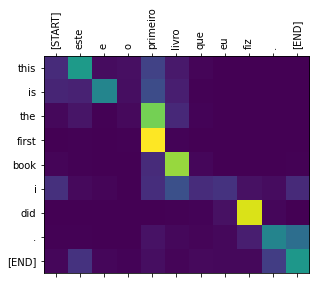

In [75]:
%matplotlib inline

plot_attention_head(in_tokens, translated_tokens, attention)

In [76]:
def plot_attention_weights(in_tokens, translated_tokens, attention):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    in_tokens
    
    fig = plt.figure(figsize=(16, 8))
    
    for h, head in enumerate(attention_heads):
        
        ax = fig.add_subplot(2, 4, h+1)
        
        plot_attention_head(in_tokens, translated_tokens, head)
        
        ax.set_xlabel('Head {}'.format(h+1))
        
    plt.tight_layout()
    plt.show()

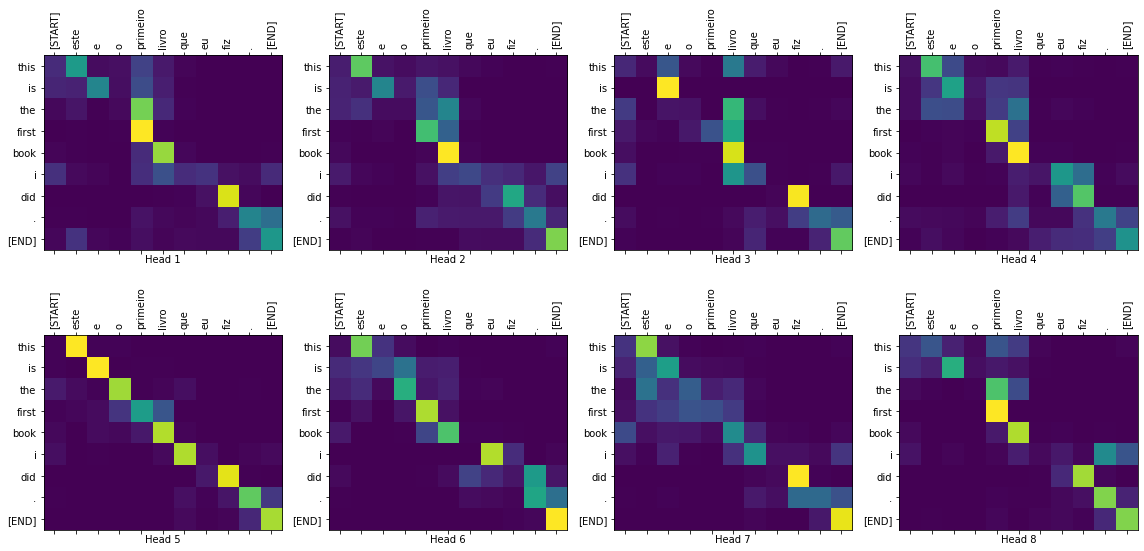

In [77]:
%matplotlib inline
plot_attention_weights(in_tokens, translated_tokens, attention)

# Plot 2

In [78]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

In [79]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trilorits in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


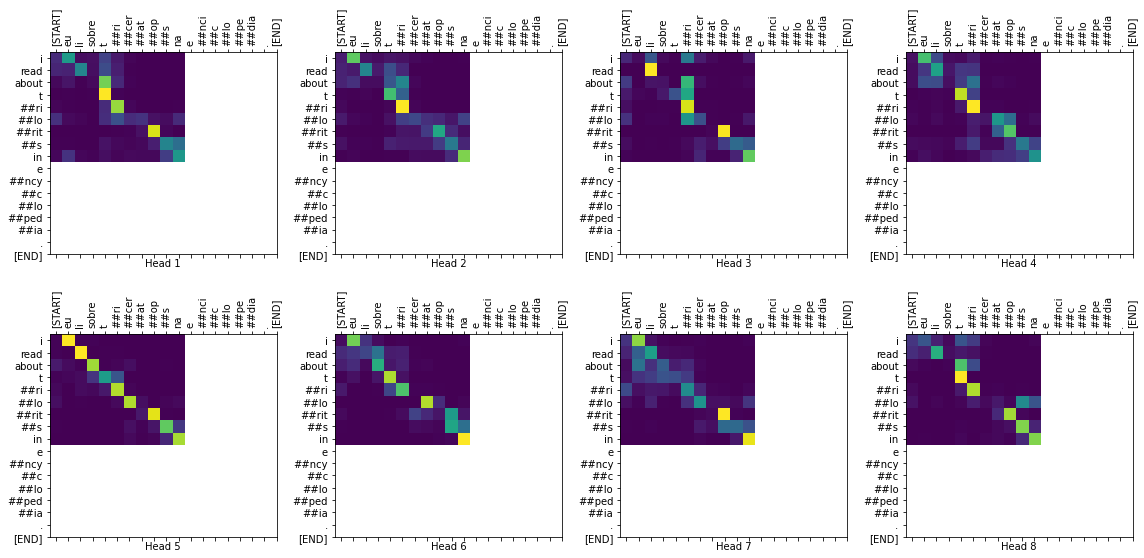

In [80]:
%matplotlib inline
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])